In [ ]:
# load csv data and such
import pandas as pd
import os
import glob
from dask import dataframe as dd
dpath = "/glade/u/home/cjreed/data/ukesm/"
'''
...
snotel_metrics.npy
wrf_bas_metrics.npy
wrf_pt_metrics_2.npy
wrf_pt_metrics.npy
'''

res = dd.read_csv(os.path.join(dpath, "*.csv"), parse_dates=["Unnamed: 0", "maxdate"], blocksize=None)
print(res.head())


: 

In [20]:
# res.compute()

aa = res.partitions[0]

<AxesSubplot: >

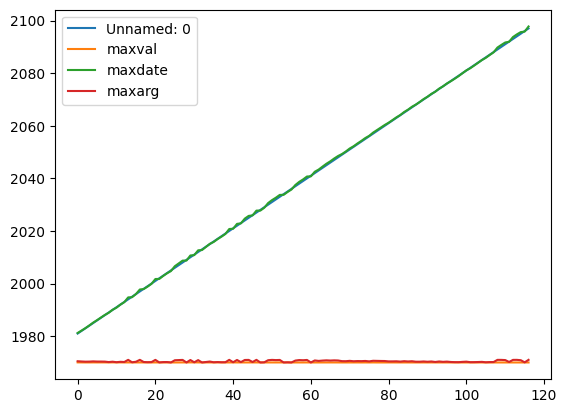

In [21]:
aa.compute().plot()

In [3]:
res[0]

KeyError: 0